In [46]:
import pathlib

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_docs as tfdocs

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow_docs.plots
import tensorflow_docs.modeling

from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 3us/step


'/home/tsunderex/.keras/datasets/auto-mpg.data'

In [11]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = '?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [12]:
dataset = raw_dataset.copy()
dataset.head()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1

In [13]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [15]:
dataset.dropna(inplace=True)
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [18]:
dataset.dtypes

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Origin            int64
dtype: object

In [20]:
origin_dict = {1: 'USA', 2: 'Europe', 3: 'Japan'}
dataset['Origin'] = dataset['Origin'].map(origin_dict)

In [21]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.head()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Europe  Japan  USA  
0          70       0      0    1  
1          70       0      0    1  
2          70       0      0    1  
3          70       0      0    1  
4          70       0      0    1

In [22]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [23]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [24]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
Europe           0.00     1.0  
Japan            0.00     1.0  
USA              1.00     1.0

In [25]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [26]:
def norm(x):
    return (x - train_stats['mean']) / (train_stats['std'])
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [33]:
def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(loss='mse',
                  optimizer=RMSprop(0.001),
                  metrics=['mae', 'mse'])
    
    return model

In [35]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [39]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch.values)
example_result

array([[-0.2080153 ],
       [-0.05657046],
       [-0.38343334],
       [-0.0564272 ],
       [-0.04208346],
       [-0.12091851],
       [-0.03155357],
       [-0.30097556],
       [-0.1451092 ],
       [-0.17005484]], dtype=float32)

In [40]:
EPOCHS = 1000
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:581.3473,  mae:22.8922,  mse:581.3472,  val_loss:577.7168,  val_mae:22.8130,  val_mse:577.7169,  
....................................................................................................
Epoch: 100, loss:5.8118,  mae:1.7085,  mse:5.8118,  val_loss:9.3555,  val_mae:2.1945,  val_mse:9.3555,  
....................................................................................................
Epoch: 200, loss:5.3021,  mae:1.5928,  mse:5.3021,  val_loss:8.4215,  val_mae:2.1880,  val_mse:8.4215,  
....................................................................................................
Epoch: 300, loss:4.7217,  mae:1.4386,  mse:4.7217,  val_loss:8.2923,  val_mae:2.2083,  val_mse:8.2923,  
....................................................................................................
Epoch: 400, loss:4.1186,  mae:1.3640,  mse:4.1186,  val_loss:8.9949,  val_mae:2.2988,  val_mse:8.9949,  
..............................................................

In [42]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

loss        mae         mse    val_loss    val_mae     val_mse  epoch
0  581.347275  22.892244  581.347229  577.716825  22.813015  577.716858      0
1  537.308191  21.969318  537.308167  531.518022  21.840784  531.518005      1
2  494.880371  21.030939  494.880371  482.960223  20.753618  482.960205      2
3  448.366521  19.963848  448.366516  428.915828  19.476278  428.915833      3
4  396.752962  18.700495  396.752991  368.930427  17.954794  368.930420      4

Text(0, 0.5, 'MAE [MPG]')

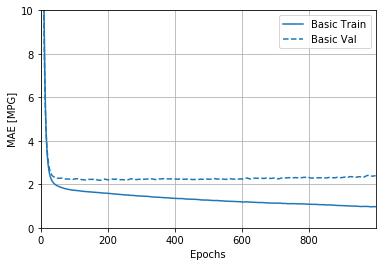

In [44]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric='mae')
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

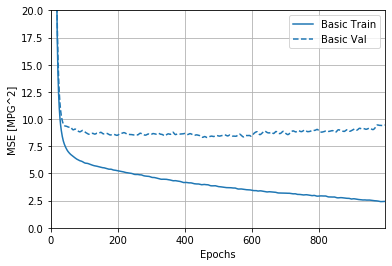

In [45]:
plotter.plot({'Basic': history}, metric='mse')
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [47]:
model = build_model()
early_stop = EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels,
                          epochs=EPOCHS, validation_split=0.2, verbose=0,
                          callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:564.3720,  mae:22.5647,  mse:564.3719,  val_loss:548.4195,  val_mae:22.2311,  val_mse:548.4194,  
...........................................................................................

Text(0, 0.5, 'MAE [MPG]')

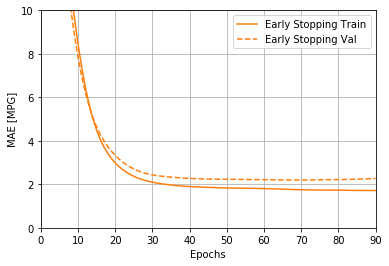

In [48]:
plotter.plot({'Early Stopping': early_history}, metric='mae')
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [49]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print(f"Testing set Mean Abs Error: {mae:.2f} MPG")

78/78 - 0s - loss: 5.5674 - mae: 1.7928 - mse: 5.5674
Testing set Mean Abs Error: 1.79 MPG


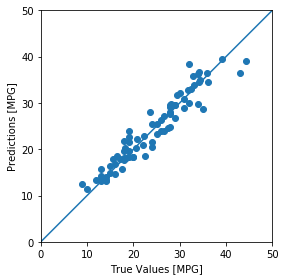

In [51]:
test_predictions = model.predict(normed_test_data).flatten()

plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)
plt.tight_layout()

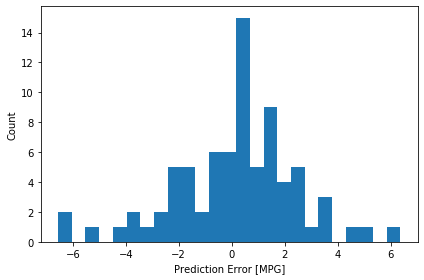

In [52]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
plt.ylabel('Count')
plt.tight_layout()